In [26]:
import torch
from torch import nn
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
import torchbearer

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

In [27]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# Hyper-parameters
num_epochs = 150
batch_size = 64
learning_rate = 0.01

Files already downloaded and verified
Files already downloaded and verified


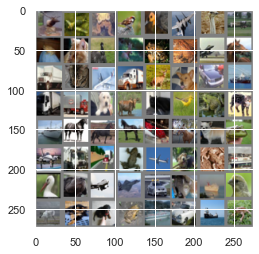

In [29]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomAffine(0, translate=(0.1,0.1))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [30]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.covModule = nn.Sequential(
            #input a 3x32x32 image
            nn.Conv2d(3, 64, (5,5)),  #image size will be 64x28x28
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),#image size will be 64x14x14
            nn.Conv2d(64, 64, (5,5)), #image size will be 64x10x10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), #image size will be 64x5x5
            nn.Conv2d(64, 128, (5,5)), #image size will be 64x1x1
            nn.ReLU(),
            #nn.MaxPool2d(2, 2), last maxpool layer cannot work
        )
        self.fcModule = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            #nn.Softmax() #no need for softmax ans CrossEntropy loss already has it
        )
    def forward(self, x):
        x = self.covModule(x)
        x = x.view(-1, 1*1*128)
        output = self.fcModule(x)
        return output

In [31]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(title + '.png')

In [32]:
model = ConvNet().to(device)
ModelName = 'CNN'

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=0.9)
opt = 'Nesterov'

In [33]:
epochs = []
n_total_steps = len(train_loader)
train_loss_average = torch.zeros(num_epochs)
valid_loss_average = torch.zeros(num_epochs)
train_accuracy = torch.zeros(num_epochs)
valid_accuracy = torch.zeros(num_epochs)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,120], gamma=0.1)


In [34]:

def train():

    model.train()
    running_train_loss = 0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        train_step_loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        train_step_loss.backward()
        optimizer.step()

        running_train_loss += train_step_loss.item()

        #predictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100.*correct/total

    #get the training losses and accuracies
    train_loss_average[epoch] = running_train_loss/len(train_loader)
    train_accuracy[epoch] = accuracy

    print(f'Training Loss: {running_train_loss/len(train_loader)}\t \
            Training accuracy: {train_accuracy[epoch]}')


In [35]:
def test():
    model.eval()

    running_valid_loss = 0
    correct = 0
    total = 0

    #validation loop
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            valid_step_loss = criterion(outputs, labels)

            running_valid_loss += valid_step_loss.item()

            #predictions
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.*correct/total

    #get the validation losses
    valid_loss_average[epoch] = running_valid_loss/len(test_loader)
    valid_accuracy[epoch] = accuracy


    print(f'Validation Loss: {running_valid_loss/len(test_loader)}\t \
            Validation accuracy: {valid_accuracy[epoch]}\t \
            LR:{curr_lr}')

In [36]:
start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    train()
    test()

    epochs.append(epoch)

    #get the current learning rate
    curr_lr = optimizer.param_groups[0]['lr']

    #step the learning rate scheduler
    scheduler.step()


print("--- %s seconds ---" % (time.time() - start_time))
print('Finished Training')


Epoch: 1
Training Loss: 1.7998722558436187	             Training accuracy: 32.928001403808594


NameError: name 'curr_lr' is not defined

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels, predicted):
            if (label == prediction):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {class_acc} %')



In [ ]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(title + '.png')


In [ ]:
#plot the loss diagrams and save
plotLosses(epochs, train_loss_average, f'CNN-{opt}_train_loss lr:{learning_rate} acc:{acc}')
plotLosses(epochs, valid_loss_average, f'CNN-{opt}_valid_loss lr:{learning_rate} acc:{acc}')

#plot the loss diagrams and save
plt.figure(figsize=(10,6))
plt.title(f'CNN-{opt} lr:{learning_rate} acc:{acc}')
plt.plot(epochs, train_loss_average, label = "Training loss")
plt.plot(epochs, valid_loss_average, label = 'Validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(f'CNN-Loss-{opt} lr:{learning_rate} acc:{acc}.png')


#plot the loss diagrams and save
plt.figure(figsize=(10,6))
plt.title(f'CNN-{opt} lr:{learning_rate} acc:{acc}')
plt.plot(epochs, train_accuracy, label = "Training Accuracy")
plt.plot(epochs, valid_accuracy, label = 'Validation Accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(f'CNN-Accuracy-{opt} lr:{learning_rate} acc:{acc}.png')

PATH = f'./CNN-{opt} lr:{learning_rate} acc:{acc}.pth'
torch.save(model.state_dict(), PATH)

In [40]:
from pathlib import Path

df = pd.DataFrame(train_loss_average, columns=['train_loss'], index=[i for i in range(1,151)])
filepath = Path(f'ResultsData/trainloss/{ModelName}-{opt}-{learning_rate}-{acc}.csv')
filepath.parent.mkdir(exist_ok=True)
df.to_csv(filepath)

df = pd.DataFrame(valid_loss_average, columns=['valid_loss'], index=[i for i in range(1,151)])
filepath = Path(f'ResultsData/validloss/{ModelName}-{opt}-{learning_rate}-{acc}.csv')
filepath.parent.mkdir(exist_ok=True)
df.to_csv(filepath)

df = pd.DataFrame(train_accuracy, columns=['train_accuracy'], index=[i for i in range(1,151)])
filepath = Path(f'ResultsData/trainacc/{ModelName}-{opt}-{learning_rate}-{acc}.csv')
filepath.parent.mkdir(exist_ok=True)
df.to_csv(filepath)

df = pd.DataFrame(valid_accuracy, columns=['valid_accuracy'], index=[i for i in range(1,151)])
filepath = Path(f'ResultsData/validacc/{ModelName}-{opt}-{learning_rate}-{acc}.csv')
filepath.parent.mkdir(exist_ok=True)
df.to_csv(filepath)